In [1]:
#importação das bibliotecas necessárias

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import random
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
#tentativa de normalizar os testes
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [3]:
#padronização
img_width, img_height = 150, 150
batch_size = 32
epochs = 20

In [4]:
data_dir = pathlib.Path("C:/Users/Windows/Desktop/SEG IA PLANTS")
train_data_dir = data_dir / "train"
validation_data_dir = data_dir / "validation"


In [5]:
#contagem de imagens
image_count = len(list(data_dir.glob('*/*/*.jpg')))
print(f"Total de imagens: {image_count}")

Total de imagens: 906


Visualizando algumas imagens fixas:


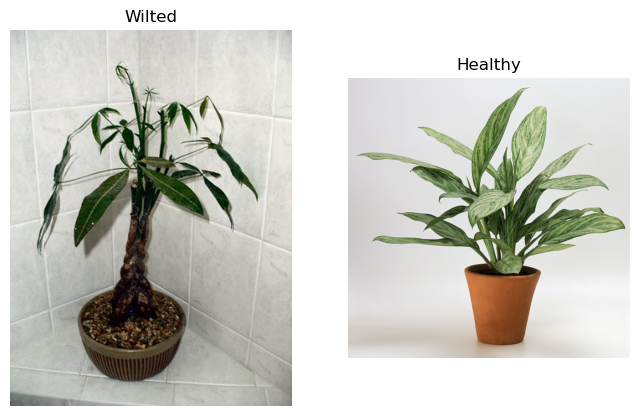

In [6]:
#visualização das imagens

wilted_images = list((train_data_dir / "wilted").glob('*.jpg'))
healthy_images = list((train_data_dir / "healthy").glob('*.jpg'))

print("Visualizando algumas imagens fixas:")
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(plt.imread(str(wilted_images[0])))
plt.title("Wilted")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(plt.imread(str(healthy_images[0])))
plt.title("Healthy")
plt.axis("off")
plt.show()

In [7]:
#classificação e geração de dados

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

validation_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical"
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical"
)


Found 457 images belonging to 2 classes.
Found 452 images belonging to 2 classes.


In [8]:
#Descrição do modelo de classificação
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


c:\Users\Windows\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:

#balanceamento
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

In [10]:
#treinamento do modelo

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=dict(enumerate(class_weights)),
    callbacks=[early_stopping]
)


c:\Users\Windows\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.4789 - loss: 0.7456 - val_accuracy: 0.5465 - val_loss: 0.6694
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7186 - loss: 0.5635 - val_accuracy: 0.6527 - val_loss: 0.6438
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6942 - loss: 0.6031 - val_accuracy: 0.6770 - val_loss: 0.5847
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7412 - loss: 0.5568 - val_accuracy: 0.6903 - val_loss: 0.5966
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7425 - loss: 0.5411 - val_accuracy: 0.6969 - val_loss: 0.5799
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7728 - loss: 0.5030 - val_accuracy: 0.6195 - val_loss: 0.7698
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7976 - loss: 0.4657 - val_accuracy: 0.7301 - val_loss: 0.5668
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7730 - loss: 0.4669 - val_accuracy: 0.6726 - val_loss:

In [12]:
model.save("modelo_plantas_domesticas.h5")


In [13]:
print("Resumo do modelo:")
model.summary()

Resumo do modelo:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,485,832 (55.26 MB)

 Trainable params: 4,828,610 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,657,222 (36.84 MB)

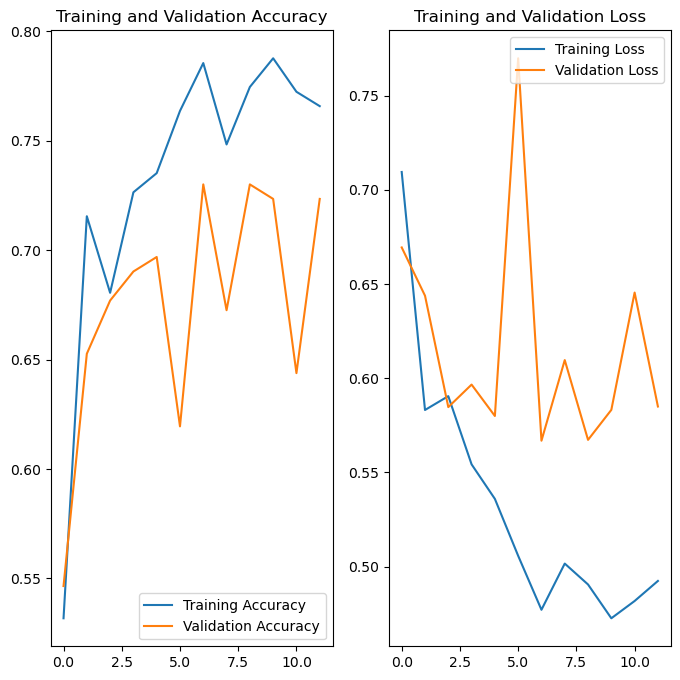

In [14]:
#visualização dos resultados do treinamento

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
def prever_imagem(model_path, image_path):
    model = load_model(model_path)
    img = tf.keras.utils.load_img(image_path, target_size=(img_width, img_height))
    img_array = tf.keras.utils.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, 0)

    prediction = model.predict(img_array)

    
    class_indices = {0: "wilted", 1: "healthy"}  
    predicted_class = class_indices[np.argmax(prediction)]
    confidence = np.max(prediction) * 100

    print(f"A previsão para a imagem é: {predicted_class} com confiança de {confidence:.2f}%")
    return predicted_class

resultado = prever_imagem("modelo_plantas_domesticas.h5", "C:/Users/Windows/Desktop/murcha_test.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
A previsão para a imagem é: wilted com confiança de 82.99%


In [20]:
#importação das bibliotecas 

import tkinter as tk
from tkinter import filedialog, Label, Button
from PIL import Image, ImageTk
import tensorflow as tf
import numpy as np


img_width, img_height = 150, 150
model_path = "modelo_plantas_domesticas.h5"

# Carregar o modelo
model = tf.keras.models.load_model(model_path)

# Função para processar a imagem e fazer a previsão
def prever_imagem(image_path):
    img = tf.keras.utils.load_img(image_path, target_size=(img_width, img_height))
    img_array = tf.keras.utils.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, 0)

    prediction = model.predict(img_array)
    class_indices = {0: 'wilted', 1: 'healthy'}  
    predicted_class = class_indices[np.argmax(prediction)]
    confidence = np.max(prediction) * 100

    return predicted_class, confidence

# Função para carregar e exibir a imagem
def upload_imagem():
    file_path = filedialog.askopenfilename(filetypes=[("Image Files", "*.jpg;*.jpeg;*.png")])
    if file_path:
        img = Image.open(file_path)
        img = img.resize((200, 200))
        img_tk = ImageTk.PhotoImage(img)

        # Atualizar o rótulo da imagem
        image_label.configure(image=img_tk)
        image_label.image = img_tk

        # Fazer a previsão
        predicted_class, confidence = prever_imagem(file_path)
        result_label.configure(text=f"Previsão: {predicted_class}\nConfiança: {confidence:.2f}%")

# Criar a interface
root = tk.Tk()
root.title("Classificador de Plantas Domésticas")

# Elementos da interface
title_label = Label(root, text="Classificador de Plantas Domésticas", font=("Helvetica", 16))
title_label.pack(pady=10)

upload_button = Button(root, text="Carregar Imagem", command=upload_imagem)
upload_button.pack(pady=10)

image_label = Label(root)
image_label.pack(pady=10)

result_label = Label(root, text="", font=("Helvetica", 12))
result_label.pack(pady=10)

# Iniciar a aplicação
root.mainloop()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
